Rows: 18143
Columns: 7557
Scale: 1.0017330185711 meters/pixel
Sub-sampling: 10
New scale: 10.017330185711 meters/pixel


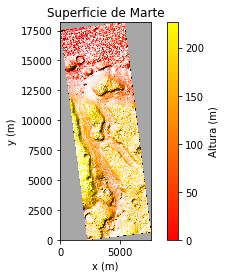

In [1]:
#Cargar el mapa
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

import struct
import copy
import math

# Archivo de datos
data_file = open("data.bin", "rb")

# Cantidad de renglones de la imagen (INT32, 4 bytes)
data = data_file.read(4)
n_rows = int.from_bytes(data, byteorder='little')
print('Rows:', n_rows)

# Cantidad de columnas de la imagen (INT32, 4 bytes)
data = data_file.read(4)
n_columns = int.from_bytes(data, byteorder='little')
print('Columns:', n_columns)

# Escala de la imagen (metros/pixel) (FLOAT64, 8 bytes)
data = data_file.read(8)
scale = struct.unpack('d', data)
scale = scale[0]
print('Scale:', scale, 'meters/pixel')

# Datos de la imagen (arreglo de números códificados en float64, 8 bytes por cada pixel)
image_size = n_rows * n_columns
data = data_file.read(8*image_size) 

# Transforma los datos de la imagen en un arreglo de numpy
image_data = np.frombuffer(data)
image_data = image_data.reshape((n_rows, n_columns))


# Submuestrea la imagen original para reducir su tamaño (también es posible escalara la imagen)
sub_rate = 10
scale = sub_rate*scale
image_data = image_data[0::sub_rate, 0::sub_rate]
n_rows, n_columns = image_data.shape

print('Sub-sampling:', sub_rate)
print('New scale:', scale, 'meters/pixel')

# Superfice en 2D
cmap = copy.copy(plt.cm.get_cmap('autumn'))
cmap.set_under(color='black')   

ls = LightSource(315, 45)
rgb = ls.shade(image_data, cmap=cmap, vmin = 0, vmax = image_data.max(), vert_exag=2, blend_mode='hsv')

fig, ax = plt.subplots()

im = ax.imshow(rgb, cmap=cmap, vmin = 0, vmax = image_data.max(), 
                extent =[0, scale*n_columns, 0, scale*n_rows], 
                interpolation ='nearest', origin ='upper')

cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Altura (m)')

plt.title('Superficie de Marte')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

In [2]:
def check_pixel(current_x, current_y, navmap):
    if current_x == navmap.shape[1] - 1:
        next_x = current_x
    else:
        next_x = current_x + 1
    if current_x == 0:
        prev_x = current_x
    else:
        prev_x = current_x - 1
        
    if current_y == navmap.shape[0] - 1:
        next_y = current_y
    else:
        next_y = current_y + 1
    if current_y == 0:
        prev_y = current_y
    else:
        prev_y = current_y - 1
        
    if abs(navmap[current_y][current_x] - navmap[prev_y][prev_x]) > 1:
        return True
    elif abs(navmap[current_y][current_x] - navmap[next_y][next_x]) > 1:
        return True
    elif abs(navmap[current_y][current_x] - navmap[next_y][prev_x]) > 1:
        return True
    elif abs(navmap[current_y][current_x] - navmap[prev_y][next_x]) > 1:
        return True
    elif abs(navmap[current_y][current_x] - navmap[current_y][next_x]) > 1:
        return True
    elif abs(navmap[current_y][current_x] - navmap[current_y][prev_x]) > 1:
        return True
    elif abs(navmap[current_y][current_x] - navmap[next_y][current_x]) > 1:
        return True
    elif abs(navmap[current_y][current_x] - navmap[prev_y][current_x]) > 1:
        return True
    else:
        return False
        

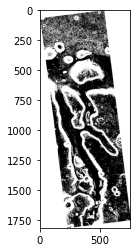

In [3]:
#Leer los datos de altura y generar arreglo con valores 1 y 0 para saber por donde puede viajar el rober
nav_map = []
for y,r in enumerate(image_data):
    ren = []
    for x,c in enumerate(r):
        if c == -1 or check_pixel(x,y,image_data):
            ren.append(1)
        else:
            ren.append(0)
    nav_map.append(ren)
    
navmap = np.stack(nav_map)
fig, ax = plt.subplots()
ax.imshow(navmap, cmap="gray")
plt.show()

In [4]:
class Node:
    pre = None
    def __init__(self, x, y, value):
        self.x = x
        self.y = y
        self.value = value

In [5]:
from scipy.spatial import distance
def calculate_F_cost(start, end, parent, current):
    G_cost = distance.euclidean(parent, start) + distance.euclidean(current, parent)
    H_cost = distance.euclidean(current, end)
    return G_cost+H_cost

In [6]:
def A_star_static(start_point, end_point, nav_map, check_manhattan_distance = True):
    route = np.zeros_like(rgb)
    node_map = []
    for y,row in enumerate(nav_map):
        node_map_row = []
        for x, col in enumerate(row):
            node_map_row.append(Node(x,y,nav_map[y][x]))
        node_map.append(node_map_row)
    
    open_nodes = []
    open_f_costs = []
    closed_nodes = []
    
    x0 = start_point[0]
    y0 = start_point[1]
    xf = end_point[0]
    yf = end_point[1]
    
    origin_node = node_map[start_point[1]][start_point[0]]
    target_node = node_map[end_point[1]][end_point[0]]
    
    open_nodes.append(origin_node)
    open_f_costs.append(calculate_F_cost(start_point, end_point, start_point, start_point))
    capa = 0
    
    while len(open_nodes) > 0 and capa < distance.cityblock(start_point, end_point)*100:
        if check_manhattan_distance:
            capa += 1
        current = open_nodes.pop(open_f_costs.index(min(open_f_costs)))
        open_f_costs.pop(open_f_costs.index(min(open_f_costs)))
        closed_nodes.append(current)
        
        if current == target_node:
            return current
            break
        else:
            #Start neighbor search
            neighbors = []
            for check_x in [-1,0,1]:
                for check_y in [-1,0,1]:
                    if node_map[current.y + check_y][current.x + check_x].value == 0 and not node_map[current.y + check_y][current.x + check_x] in closed_nodes:
                        neighbors.append(node_map[current.y + check_y][current.x + check_x])
            #Finished neighbor search
            for n in neighbors:
                if not n in open_nodes:
                    n.pre = current
                    open_nodes.append(n)
                    open_f_costs.append(calculate_F_cost(start_point, end_point, (n.pre.x, n.pre.y),(n.x, n.y)))
                elif calculate_F_cost(start_point, end_point, (current.x, current.y), (n.x, n.y)) < open_f_costs[open_nodes.index(n)]:
                    open_nodes[open_nodes.index(n)].pre = current
                    open_f_costs[open_nodes.index(n)] = calculate_F_cost(start_point, end_point, (current.x, current.y), (n.x, n.y))
    return closed_nodes
            
    

In [7]:
#Prueba del algoritmo A*

In [8]:
start = np.array((2850, 6400)) // sub_rate
goal = np.array((3150, 6800)) // sub_rate
if navmap[start[1]][start[0]] == 1:
    print('El punto de salida se encuentra en un punto no navegable')
elif navmap[goal[1]][goal[0]] == 1:
    print('La meta se encuentra en un punto no navegable')
else:
    path = A_star_static(start, goal, navmap)

La meta se encuentra en un punto no navegable


In [27]:
def print_map(path, navmap):
    route = np.zeros_like(rgb)
    try:
        point = path
        while not point.pre == None:
            point = point.pre
            route[point.y][point.x][1] = 1
            route[point.y][point.x][3] = 1
    
    except:
        for i in path:
            route[i.y][i.x][0] = 1
            route[i.y][i.x][3] = 1
        
    
    for i in range(0,3):
        for j in range(0,3):
            route[start[1]+j][start[0]+i][0] = 1
            route[start[1]+j][start[0]+i][3] = 1
    
            route[goal[1]+j][goal[0]+i][2] = 1
            route[goal[1]+j][goal[0]+i][3] = 1
    
    fig, ax = plt.subplots()
    ax.imshow(navmap, cmap="gray")
    ax.imshow(route)
    fig.set_size_inches(100, 60)
    #fig.savefig('RouteMap.png', dpi=100)
    
    plt.title('Superficie de Marte')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.show()

Distancia entre los puntos: 360.5551275463989 metros


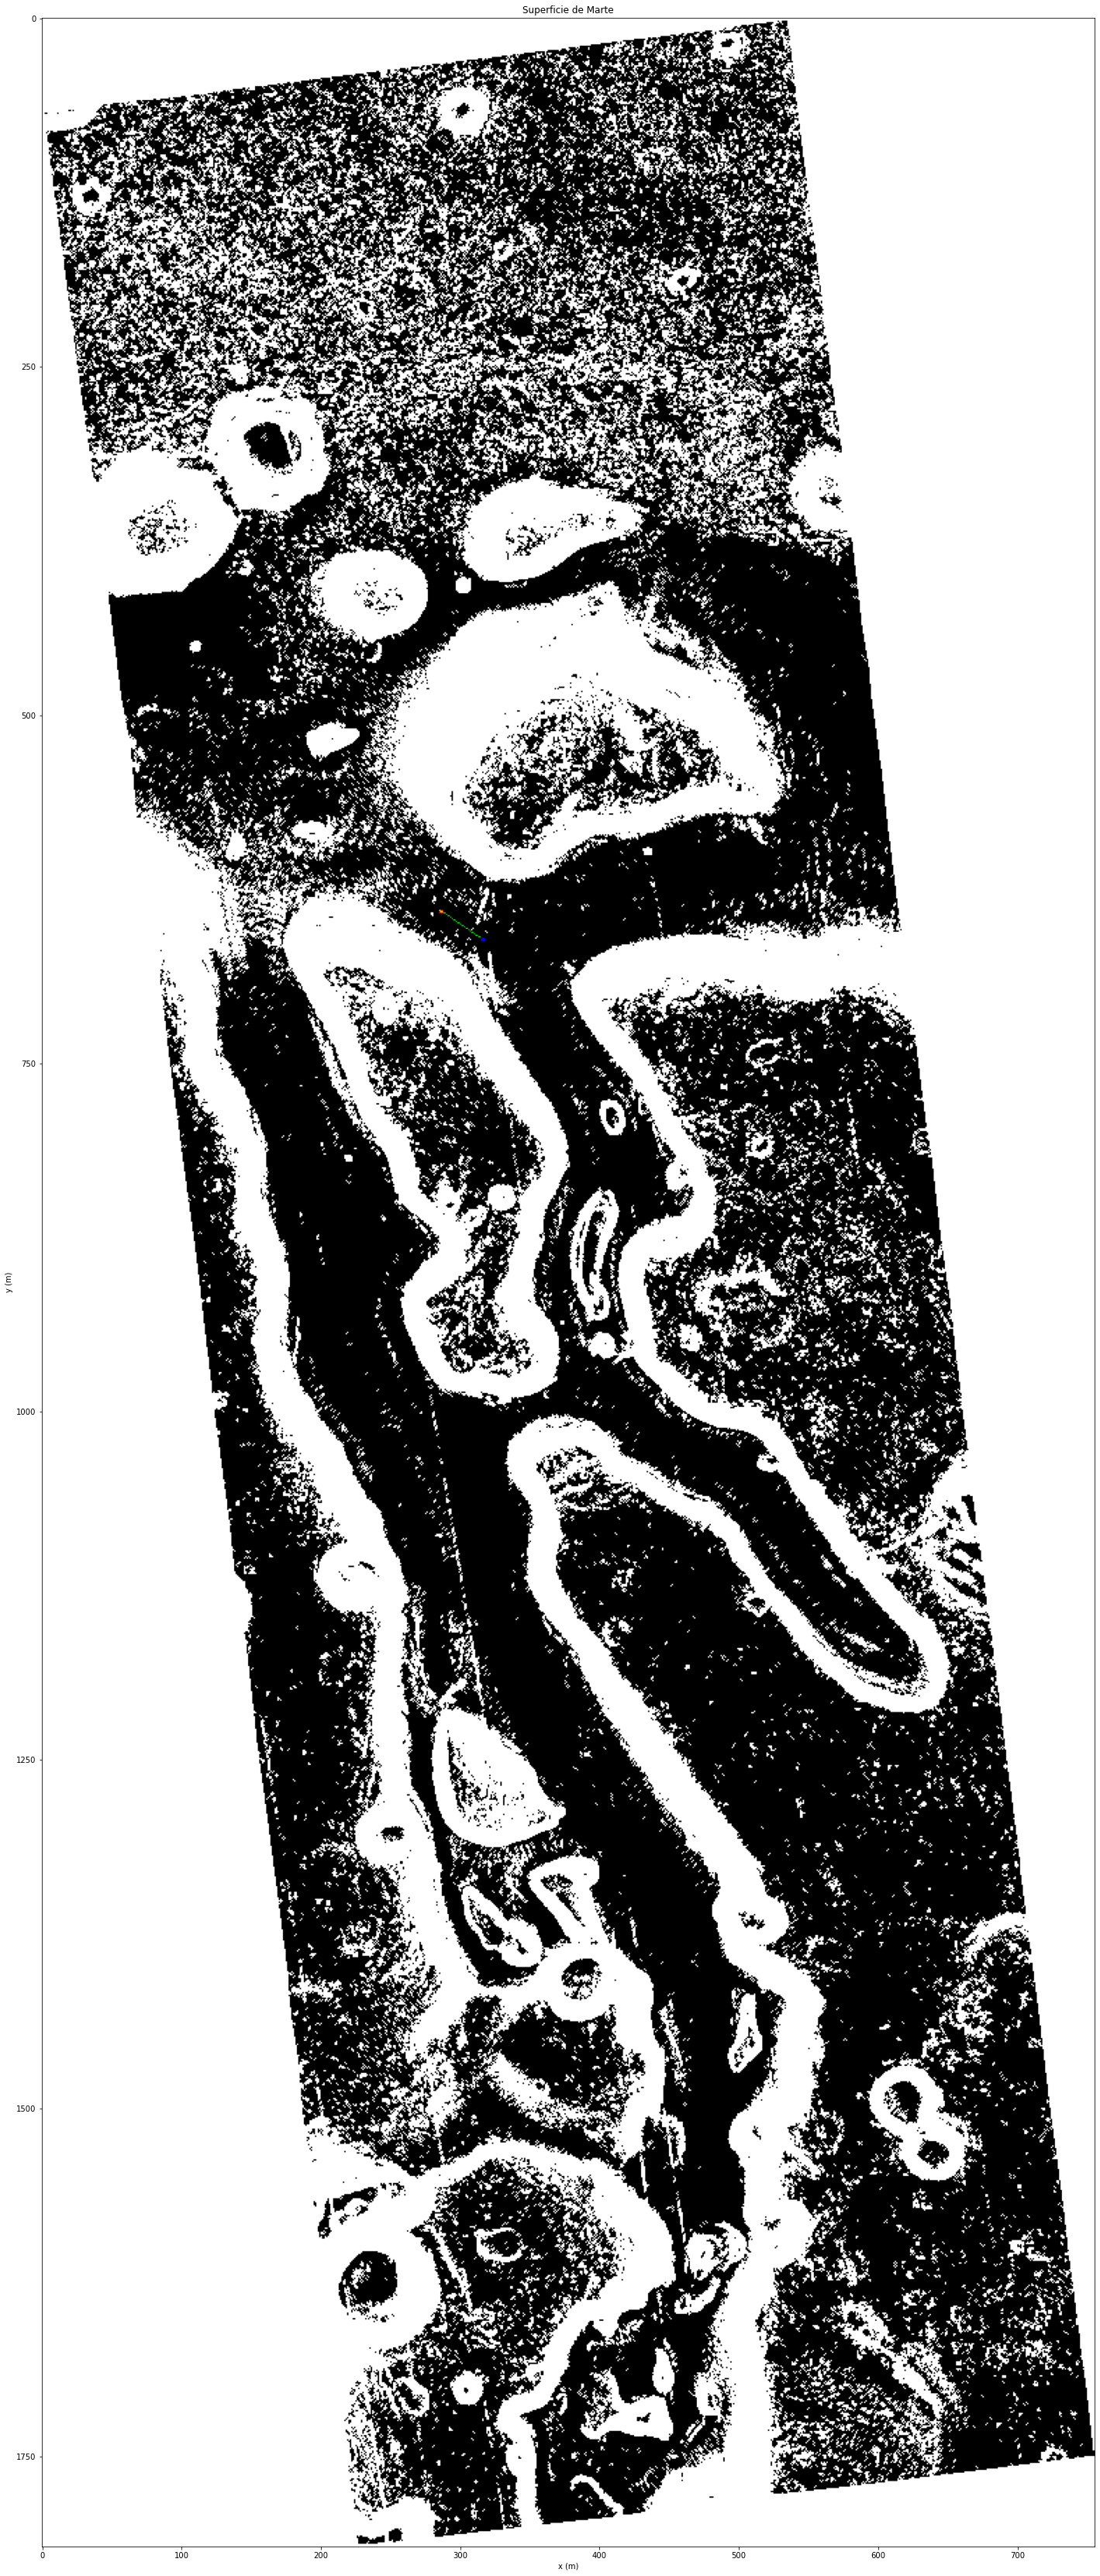

In [28]:
#Prueba a una distancia corta
start = np.array((2850, 6400)) // sub_rate
goal = np.array((3150, 6600)) // sub_rate
if navmap[start[1]][start[0]] == 1:
    print('El punto de salida se encuentra en un punto no navegable')
elif navmap[goal[1]][goal[0]] == 1:
    print('La meta se encuentra en un punto no navegable')
else:
    print('Distancia entre los puntos:', distance.euclidean(start,goal)*sub_rate, "metros")
    path = A_star_static(start, goal, navmap)
print_map(path, navmap)

In [14]:
#Prueba a una distancia mediana
start = np.array((1500, 7500)) // sub_rate
goal = np.array((5000, 6000)) // sub_rate
if navmap[start[1]][start[0]] == 1:
    print('El punto de salida se encuentra en un punto no navegable')
elif navmap[goal[1]][goal[0]] == 1:
    print('La meta se encuentra en un punto no navegable')
else:
    print('Distancia entre los puntos:', distance.euclidean(start,goal)*sub_rate, "metros")
    path = A_star_static(start, goal, navmap, False)
print_map(path, navmap)

Distancia entre los puntos: 3807.886552931954 metros


KeyboardInterrupt: 

In [ ]:
#Prueba a una distancia Larga
start = np.array((5000, 4000)) // sub_rate
goal = np.array((3100, 13900)) // sub_rate
if navmap[start[1]][start[0]] == 1:
    print('El punto de salida se encuentra en un punto no navegable')
elif navmap[goal[1]][goal[0]] == 1:
    print('La meta se encuentra en un punto no navegable')
else:
    print('Distancia entre los puntos:', distance.euclidean(start,goal)*sub_rate, "metros")
    path = A_star_static(start, goal, navmap, False)
print_map(path, navmap)

# ¿En qué casos el algoritmo es capaz de resolver el problema en un tiempo aceptable? 

En los casos en los que la distancia entre el punto objetivo y el punto de salida es corta, ya que si nos encontramos con casos como el de la distancia mediana o la distancia larga le tomaría al algoritmo varios segundos o hasta minutos en encontrar un camino óptimo. 

En los casos en los que solo se vaya a hacer una vez el cálculo podemos usarlo para la distancia que sea y ya solo decirle al robot a donde se tiene que mover en el siguiente turno (nodo).

# En los casos que el algoritmo no encuentra un resultado, ¿qué acciones se podrían realizar para ayudar al algoritmo a resolver el problema?

Se podría agregar un algoritmo que nos dijera primero si el punto a alcanzar no esta rodeado por puntos no navegables, ya que de ser asi el algoritmo no encontrará nunca una solución al problema y tendría que recorrer todo el mapa para solucionarlo, lo cual tomaría mucho tiempo en mapas grandes como este.

Otra opción sería la que implementé de hacer un número limitado de pasos, con el fin de que si este se sobrepasa no tengamos que andar por más lugares y solo se pueda intuir el que no hay un camino posible (aunque con este método se tenría que establecer un parámetro para que no se exceda mucho ni se quede muy corto, en el caso de este código no se hace un análisis pero se podría calculando la cantidad de puntos no navegables entre los puntos y agregando ese valor al número limitado de pasos).
